In [1]:
import os

os.environ['JAX_PLATFORMS'] = 'cuda'
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '1.0'

os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

import dataclasses

import astropy.coordinates as ac
import astropy.time as at
import astropy.units as au
import jax
import jax.numpy as jnp
import numpy as np
import pylab as plt
import tensorflow_probability.substrates.jax as tfp
from tomographic_kernel.frames import ENU

from dsa2000_cal.assets.content_registry import fill_registries
from dsa2000_cal.assets.registries import array_registry
from dsa2000_cal.common.mixed_precision_utils import mp_policy
from dsa2000_cal.common.quantity_utils import quantity_to_jnp

tfpd = tfp.distributions

/dsa/code/package/src/dsa2000_cal/common/mixed_precision_utils.py:10: UserWarning: JAX x64 is not enabled. Setting it now, but check for errors.
  warnings.warn("JAX x64 is not enabled. Setting it now, but check for errors.")


In [2]:

from jax._src.partition_spec import PartitionSpec
from jax.experimental.shard_map import shard_map
from typing import Tuple
from dsa2000_cal.common.jax_utils import create_mesh


def rotate_coords_to_dec0(antennas: jax.Array, latitude: jax.Array) -> jax.Array:
    east, north, up = antennas[..., 0], antennas[..., 1], antennas[..., 2]
    east_prime = east
    north_prime = jnp.cos(latitude) * north - jnp.sin(latitude) * up
    up_prime = jnp.sin(latitude) * north + jnp.cos(latitude) * up
    return jnp.stack([east_prime, north_prime, up_prime], axis=-1)


def compute_psf(antennas: jax.Array, lmn: jax.Array, freq: jax.Array, latitude: jax.Array) -> jax.Array:
    """
    Compute the point spread function of the array
    
    Args:
        antennas: [N, 3]
        lmn: [..., , 3]
        freq: []

    Returns:
        psf: [...]
    """
    mesh = create_mesh((len(jax.devices()),), ('shard',), devices=jax.devices())

    @partial(
        shard_map,
        mesh=mesh,
        in_specs=(PartitionSpec(), PartitionSpec('shard', ), PartitionSpec(), PartitionSpec()),
        out_specs=PartitionSpec('shard', )
    )
    def compute_shard_psf(antennas, lmn_shard, freq, latitude):
        antennas = rotate_coords_to_dec0(antennas, latitude)
        wavelength = mp_policy.cast_to_length(299792458. / freq)
        r = antennas / wavelength
        delay = mp_policy.cast_to_vis(
            -2j * jnp.pi * jnp.sum(r[..., :2] * lmn_shard[..., None, :2], axis=-1))  # [..., N]
        N = antennas.shape[0]
        voltage_beam = jnp.mean(jnp.exp(delay), axis=-1)  # [...]
        power_beam = jnp.reciprocal(N - 1) * (N * (voltage_beam * voltage_beam.conj()).real - 1)
        psf = power_beam  # [...]
        return psf

    return compute_shard_psf(antennas, lmn, freq, latitude)


@dataclasses.dataclass(eq=False)
class OptimisationProblem:
    batch_size: int = 1024
    num_radial_bins: int = 3600 // 8
    num_theta_bins: int = 10
    lmax: au.Quantity = 1 * au.deg
    lmin: au.Quantity = 8 * au.arcsec
    fwhm: au.Quantity = 3.3 * au.arcsec
    freq: au.Quantity = 1350. * au.MHz
    fwhm_error_scale: float = np.log(1.02)
    sidelobe_error_scale: float = np.log(2.)

    def __post_init__(self):
        self.devices = jax.devices()
        self.mesh = create_mesh((len(self.devices),), ('shard',), devices=self.devices)

    def create_data(self, antennas: ac.EarthLocation, obstime: at.Time, array_location: ac.EarthLocation):
        lmax = quantity_to_jnp(self.lmax, 'rad')
        lmin = quantity_to_jnp(self.lmin, 'rad')
        fwhm = quantity_to_jnp(self.fwhm, 'rad')
        radii = jnp.concatenate([0.5 * fwhm[None], jnp.linspace(lmin, lmax, self.num_radial_bins)])
        theta = jnp.linspace(0., 2 * np.pi, self.num_theta_bins, endpoint=False)

        R, Theta = jnp.meshgrid(
            radii, theta,
            indexing='ij'
        )

        L = R * jnp.cos(Theta)
        M = R * jnp.sin(Theta)
        N = jnp.sqrt(1 - L ** 2 - M ** 2)
        lmn = jnp.stack([L, M, N], axis=-1)  # [Nr, Nt, 3]

        antenna_enu_xyz = antennas.get_itrs(
            obstime=obstime, location=array_location).transform_to(
            ENU(obstime=obstime, location=array_location)).cartesian.xyz.to('m').T

        antennas0 = quantity_to_jnp(antenna_enu_xyz, 'm')  # [N, 3]

        freq = quantity_to_jnp(self.freq, 'Hz')

        latitude = quantity_to_jnp(array_location.geodetic.lat)

        return antennas0, lmn, freq, latitude

    @staticmethod
    def compute_mu_sigma_X(mu_Y, sigma_Y):
        # Compute the standard deviation of X
        sigma_X = jnp.sqrt(jnp.log(1 + (sigma_Y ** 2) / (mu_Y ** 2)))

        # Compute the mean of X
        mu_X = jnp.log(mu_Y) - 0.5 * (sigma_X ** 2)

        return mu_X, sigma_X

    def compute_residuals(self, antenna_locations: jax.Array, lmn: jax.Array,
                          freq: jax.Array, latitude: jax.Array) -> Tuple[jax.Array, jax.Array]:
        psf = compute_psf(antenna_locations, lmn, freq, latitude)  # [Nr, Nt]
        fwhm_ring = psf[0, :]  # [Nt]
        sidelobes = psf[1:, :]  # [Nr-1, Nt]
        # Only positive psf values can be optimised by configuration
        pos_mask = sidelobes > 0
        residual_fwhm = (jnp.log(fwhm_ring) - jnp.log(0.5)) / self.fwhm_error_scale
        residual_fwhm = jnp.where(jnp.isnan(residual_fwhm), 0., residual_fwhm)
        log_sidelobe = jnp.log(sidelobes)
        sidelobes_target = jax.lax.stop_gradient(log_sidelobe) + jnp.log(0.98)
        residual_sidelobes = (log_sidelobe - sidelobes_target) / self.sidelobe_error_scale
        residual_sidelobes = jnp.where(pos_mask, residual_sidelobes, 0.)
        return residual_fwhm, residual_sidelobes


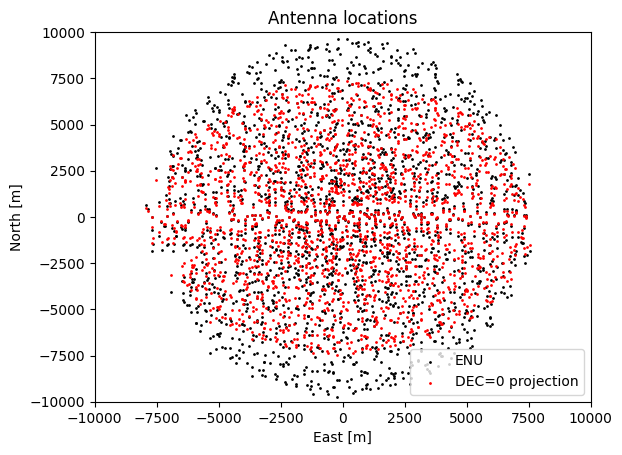

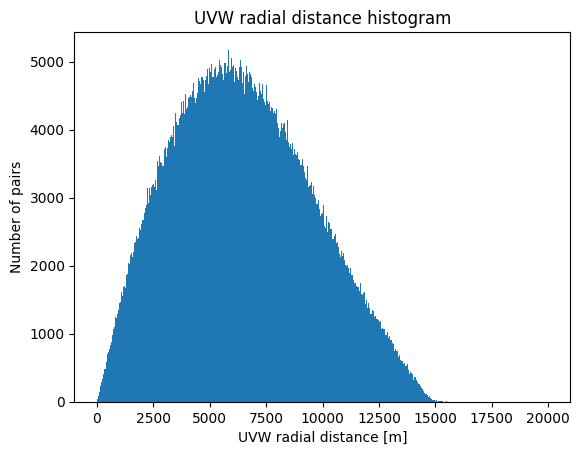

In [3]:

fill_registries()
array = array_registry.get_instance(array_registry.get_match('dsa2000_31b'))
antennas = array.get_antennas()
array_location = array.get_array_location()
obstime = at.Time('2021-01-01T00:00:00', format='isot', scale='utc')

problem = OptimisationProblem(num_radial_bins=len(jax.devices()) * 10 - 1, num_theta_bins=len(jax.devices()) * 10,
                              lmax=2 * au.arcmin)

antennas0, lmn, freq, latitude = problem.create_data(
    antennas=antennas, obstime=obstime, array_location=array_location
)

# Plot antennas in ENU
antennas_enu_xyz = antennas.get_itrs(
    obstime=obstime, location=array_location).transform_to(
    ENU(obstime=obstime, location=array_location)).cartesian.xyz.to('m').T.value

antennas_enu_xyz_rot = rotate_coords_to_dec0(antennas_enu_xyz, latitude)

plt.scatter(antennas_enu_xyz[:, 0], antennas_enu_xyz[:, 1], s=1, c='black', label='ENU')
plt.scatter(antennas_enu_xyz_rot[:, 0], antennas_enu_xyz_rot[:, 1], s=1, c='red', label='DEC=0 projection')
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.legend()
plt.title('Antenna locations')
plt.xlim(-10e3, 10e3)
plt.ylim(-10e3, 10e3)
plt.savefig('antennas.png')
plt.show()

# Plot UVW radial profile rotated to Dec=0 in bins of 10m

uvw_radial = np.linalg.norm(antennas_enu_xyz_rot[:, None, :2] - antennas_enu_xyz_rot[None, :, :2], axis=-1)
bins = np.arange(0, 20e3, 10)
uvw_radial_flat = uvw_radial.flatten()

plt.hist(uvw_radial_flat, bins=bins)
plt.xlabel('UVW radial distance [m]')
plt.ylabel('Number of pairs')
plt.title('UVW radial distance histogram')
plt.savefig('uvw_radial_hist.png')
plt.show()



[0.49599072 0.4957555  0.49556664 0.49542665 0.4953376  0.49530014
 0.49531475 0.49538064 0.49549645 0.49566004 0.49586856 0.49611875
 0.49640667 0.49672785 0.49707752 0.49745074 0.49784243 0.49824727
 0.49866006 0.4990757  0.49948943 0.49989647 0.50029266 0.5006743
 0.5010376  0.5013798  0.5016982  0.5019907  0.5022556  0.50249153
 0.5026971  0.5028719  0.5030148  0.5031255  0.5032034  0.503248
 0.5032588  0.5032353  0.5031772  0.50308377 0.50295514 0.50279087
 0.50259143 0.5023571  0.50208884 0.50178814 0.5014569  0.50109786
 0.5007141  0.50030947 0.49988836 0.49945578 0.49901706 0.498578
 0.4981445  0.49772257 0.49731836 0.49693766 0.49658614 0.49626902
 0.49599072 0.4957555  0.49556664 0.49542665 0.4953376  0.49530014
 0.49531475 0.49538064 0.49549645 0.49566004 0.49586856 0.49611875
 0.49640667 0.49672785 0.49707752 0.49745074 0.49784243 0.49824727
 0.49866006 0.4990757  0.49948943 0.49989647 0.50029266 0.5006743
 0.5010376  0.5013798  0.5016982  0.5019907  0.5022556  0.50249153
 

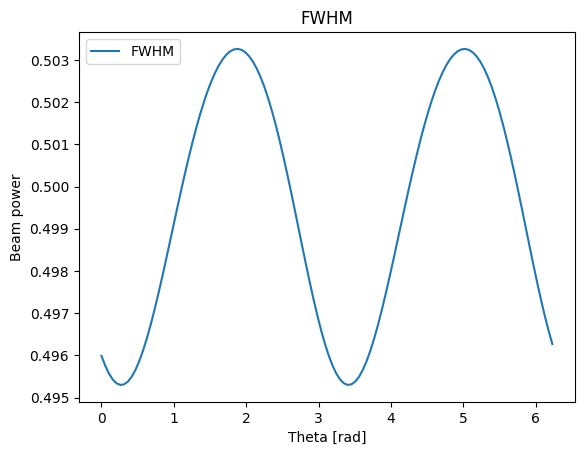

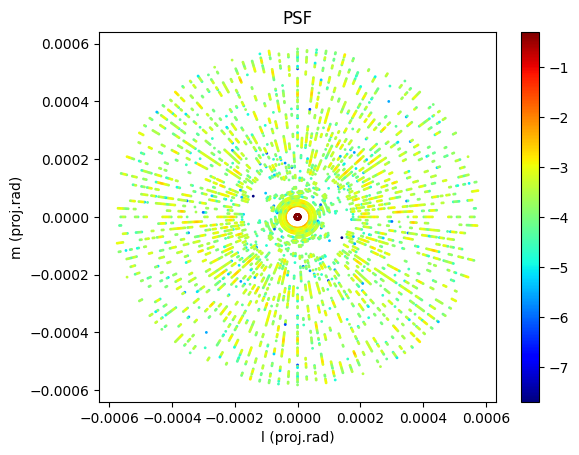

/tmp/ipykernel_1041357/3242158129.py:22: RuntimeWarning: invalid value encountered in log10
  log_psf_radii = 10 * np.log10(psf0).flatten()


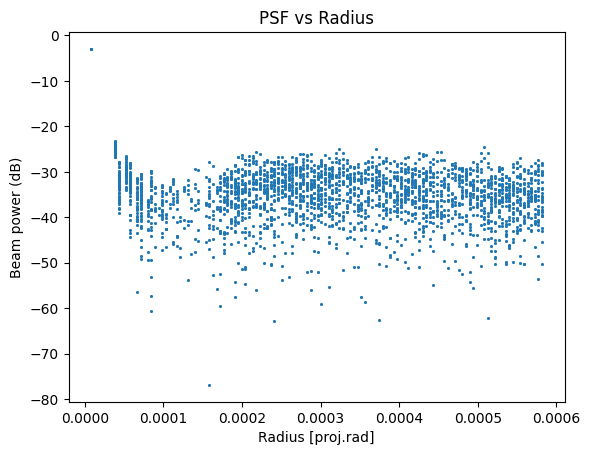

In [7]:
psf0 = jax.jit(compute_psf)(antennas0, lmn, freq, latitude)  # [Nr, Nt]
print(psf0[0, :])  # FWHM
thetas = np.linspace(0, 2 * np.pi, problem.num_theta_bins, endpoint=False)
plt.plot(thetas, psf0[0, :], label='FWHM')
plt.xlabel('Theta [rad]')
plt.ylabel('Beam power')
plt.title('FWHM')
plt.legend()
plt.savefig('fwhm.png')
plt.show()

sc = plt.scatter(
    lmn[..., 0].flatten(), lmn[..., 1].flatten(), c=jnp.log10(psf0.flatten()), s=1, cmap='jet'
)
plt.colorbar(sc)
plt.xlabel('l (proj.rad)')
plt.ylabel('m (proj.rad)')
plt.title('PSF')
plt.show()

radii = np.linalg.norm(lmn[..., :2], axis=-1).flatten()
log_psf_radii = 10 * np.log10(psf0).flatten()

plt.scatter(radii, log_psf_radii, s=1)
plt.xlabel('Radius [proj.rad]')
plt.ylabel('Beam power (dB)')
plt.title('PSF vs Radius')
plt.savefig('psf_vs_radius.png')
plt.show()




In [8]:
from scipy.spatial import KDTree


def construct_prior(x0, forbidden_points):
    """
    Construct a prior for the antenna locations
    
    Args:
        x0: [N, 2]
        forbidden_points: [S, 2]

    Returns:
        sigma: [N]
    """
    # For each point find the closest forbidden point, and compute distance using kdtree
    tree = KDTree(forbidden_points)
    d, _ = tree.query(x0)
    sigma = 0.33 * d
    return sigma

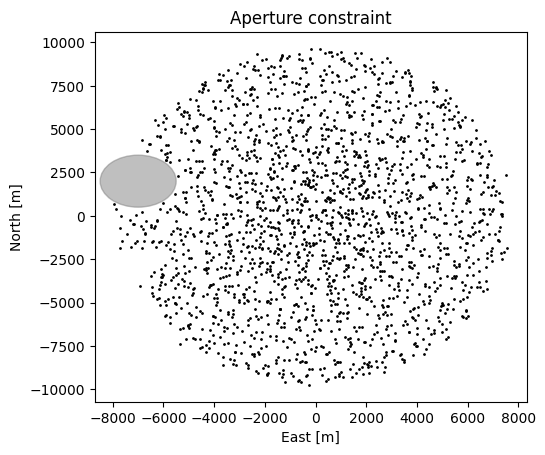

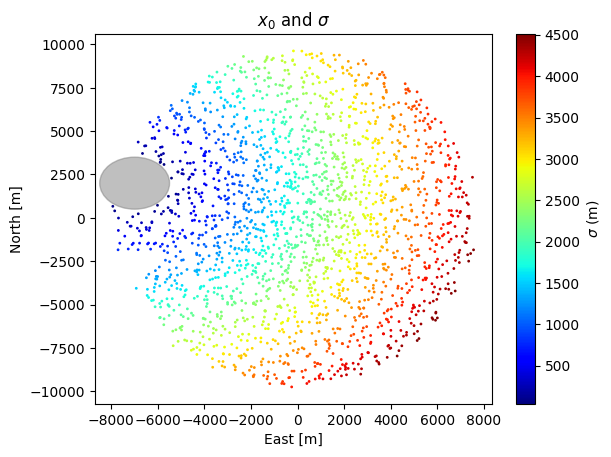

In [9]:

def sample_ball(origin, radius, num_samples: int):
    radius = radius * np.random.uniform(0, 1, num_samples) ** 0.5
    random_direction = np.random.normal(size=(num_samples, 3))
    random_direction[:, 2] = 0.
    random_direction /= np.linalg.norm(random_direction, axis=-1)[:, None]
    return origin + radius[:, None] * random_direction


# Define constaints by 
from jaxns import Model, Prior

x0 = np.array(antennas0.copy())

exclusion_center = np.asarray([-7000, 2000, 0.])
exclusion_radius = 1500

# Create forbidden samples
forbidden_points = sample_ball(exclusion_center, exclusion_radius, 2000)
# Move these antennas to another place
t = KDTree(forbidden_points)
d, _ = t.query(x0)
point_in_forbidden = d < 100.
# Choose another than is not forbidden
choose_prob = np.bitwise_not(point_in_forbidden) / jnp.sum(np.bitwise_not(point_in_forbidden))
good = np.random.choice(x0.shape[0], np.sum(point_in_forbidden), p=choose_prob, replace=True)
x0[point_in_forbidden, :2] = x0[good, :2] + np.random.normal(size=(good.size, 2)) * 100.
# For sigma make the distance to exclusion center 3 sigma, from x0
sigma = construct_prior(x0, forbidden_points)  # [n]

sc = plt.scatter(x0[:, 0], x0[:, 1], s=1, c='black')
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.title(r'Aperture constraint')

# Draw grey circle for exclusion zone
circle = plt.Circle(exclusion_center, exclusion_radius, color='grey', fill=True, alpha=0.5)
plt.gca().add_artist(circle)

plt.savefig('aperture_constraint.png')
plt.subplots_adjust(right=0.8)
plt.show()

sc = plt.scatter(x0[:, 0], x0[:, 1], s=1, c=sigma, cmap='jet')
plt.colorbar(sc, label=r'$\sigma$ (m)')
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.title(r'$x_0$ and $\sigma$')

# Draw grey circle for exclusion zone
circle = plt.Circle(exclusion_center, exclusion_radius, color='grey', fill=True, alpha=0.5)
plt.gca().add_artist(circle)

plt.savefig('x0_sigma.png')
plt.show()


In [46]:


from functools import partial
from dsa2000_cal.calibration.multi_step_lm import MultiStepLevenbergMarquardt
from jaxns import save_pytree, load_pytree


@partial(jax.jit, static_argnums=(0,))
def solve(problem, init_state, x0, sigma, lmn, freq, latitude):
    def prior_model():

        x = yield Prior(tfpd.Normal(x0[:, :2], sigma[:, None]),
                        'x').parametrised()
        x = jnp.concatenate([x, jnp.zeros((x0.shape[0], 1), x.dtype)], axis=-1)
        return x

    def log_likelihood(x):
        residuals = problem.compute_residuals(x, lmn, freq, latitude)
        return sum([-jnp.sum(jnp.square(r)) for r in jax.tree.leaves(residuals)])

    model = Model(prior_model, log_likelihood)
    U = model.sample_U(jax.random.key(0))

    def residuals(params):
        (x,) = model(params).prepare_input(U)
        return problem.compute_residuals(x, lmn, freq, latitude)

    solver = MultiStepLevenbergMarquardt(
        residual_fn=residuals,
        num_iterations=100,
        num_approx_steps=1,
        delta=2,
        mu1=100.,
        p_less_newton=0.25,
        p_sufficient_improvement=0.5,
        p_more_newton=0.8,
        c_more_newton=0.2,
        c_less_newton=1.5,
        verbose=True
    )
    if init_state is None:
        state = solver.create_initial_state(model.params)
    else:
        state = solver.update_initial_state(init_state)
    state, diagnostics = solver.solve(state)
    return model(state.x).prepare_input(U)[0], state, diagnostics


problem = OptimisationProblem(num_radial_bins=len(jax.devices()) * 20 - 1, num_theta_bins=len(jax.devices()) * 10,
                              lmax=3 * au.deg)

antennas0, lmn, freq, latitude = problem.create_data(
    antennas=antennas, obstime=obstime, array_location=array_location
)

state = None
x_iter = x0
for iteration in range(10):
    sigma = construct_prior(x_iter, forbidden_points)
    x, state, diagnostics = solve(problem, state, x0, sigma, lmn, freq, latitude)
    x_iter = x
    save_pytree(state, 'state.json')


Iter: 1, Exact Step: 0 Approx Step: 0, r: 0.1034730948477454, pred: 6.892421203661016, act: 0.7131801529370279, any_improvement: True, sufficient_improvement: False, more_newton: False, less_newton: True:
	|F|^2 -> 109.32409232495769, damping -> 30392.09766633824, mu -> 278.0, delta_norm -> 0.0001097677531578401, error -> 1637.3810429622806
Iter: 2, Exact Step: 1 Approx Step: 0, r: 0.03453484745277857, pred: 6.466678096660061, act: 0.22332574159437968, any_improvement: False, sufficient_improvement: False, more_newton: False, less_newton: True:
	|F|^2 -> 109.32409232495769, damping -> 84490.02777575699, mu -> 772.8399658203125, delta_norm -> 4.67516104288534e-05, error -> 1937.3887727606755
Iter: 3, Exact Step: 2 Approx Step: 0, r: 0.0023123887503456414, pred: 6.178698790883075, act: 0.01428755357581224, any_improvement: False, sufficient_improvement: False, more_newton: False, less_newton: True:
	|F|^2 -> 109.32409232495769, damping -> 234882.27855112703, mu -> 2148.4951171875, delta_

In [49]:
x

Array([[   31.82228025,    52.27468321,     0.        ],
       [   14.85824113,   -80.98384506,     0.        ],
       [ -153.10199885,    52.99696546,     0.        ],
       ...,
       [-7636.77847538, -1462.47089611,     0.        ],
       [ 7517.25550163,  2339.00668207,     0.        ],
       [-5343.98488643, -7376.29248045,     0.        ]], dtype=float64)

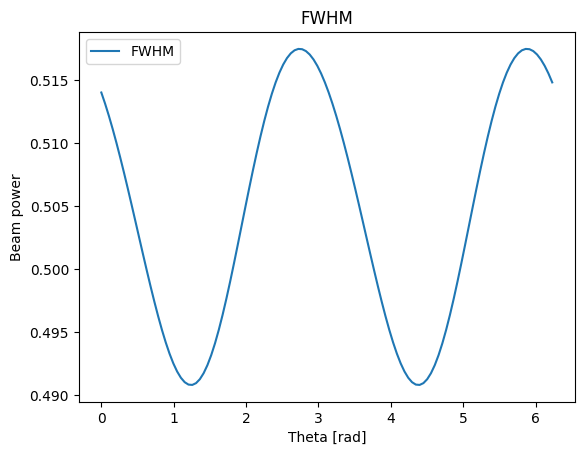

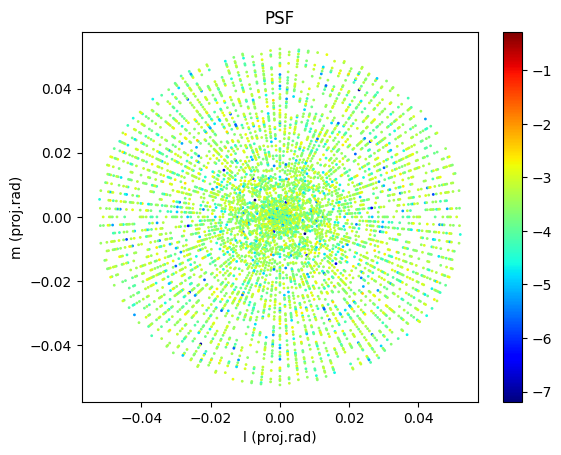

/tmp/ipykernel_1026539/2197571775.py:29: RuntimeWarning: invalid value encountered in log10
  log_psf_radii = 10 * np.log10(psf).flatten()
/tmp/ipykernel_1026539/2197571775.py:30: RuntimeWarning: invalid value encountered in log10
  log_psf0_radii = 10 * np.log10(psf0).flatten()


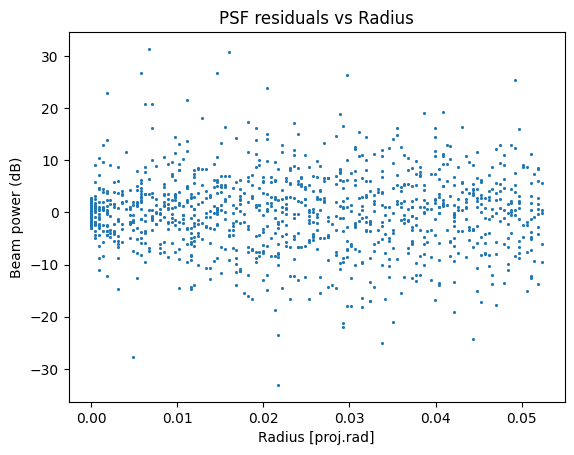

In [56]:
problem = OptimisationProblem(num_radial_bins=len(jax.devices()) * 10 - 1, num_theta_bins=len(jax.devices()) * 10,
                              lmax=3 * au.deg)

antennas0, lmn, freq, latitude = problem.create_data(
    antennas=antennas, obstime=obstime, array_location=array_location
)

psf0 = jax.jit(compute_psf)(antennas0, lmn, freq, latitude)  # [Nr, Nt]
psf = jax.jit(compute_psf)(x, lmn, freq, latitude)  # [Nr, Nt]
thetas = np.linspace(0, 2 * np.pi, problem.num_theta_bins, endpoint=False)
plt.plot(thetas, psf[0, :], label='FWHM')
plt.xlabel('Theta [rad]')
plt.ylabel('Beam power')
plt.title('FWHM')
plt.legend()
plt.savefig('fwhm.png')
plt.show()

sc = plt.scatter(
    lmn[..., 0].flatten(), lmn[..., 1].flatten(), c=jnp.log10(psf.flatten()), s=1, cmap='jet'
)
plt.colorbar(sc)
plt.xlabel('l (proj.rad)')
plt.ylabel('m (proj.rad)')
plt.title('PSF')
plt.show()

radii = np.linalg.norm(lmn[..., :2], axis=-1).flatten()
log_psf_radii = 10 * np.log10(psf).flatten()
log_psf0_radii = 10 * np.log10(psf0).flatten()
log_residuals = (log_psf_radii - log_psf0_radii)

plt.scatter(radii, log_residuals, s=1)
plt.xlabel('Radius [proj.rad]')
plt.ylabel('Beam power (dB)')
plt.title('PSF residuals vs Radius')
plt.savefig('psf_residuals.png')
plt.show()




In [46]:

save_pytree(state, 'state.json')
loaded_state = load_pytree('state.json')
loaded_state

MultiStepLevenbergMarquardtState(iteration=Array(100, dtype=int64), x={'x_param': Array([[ 0.01451474, -0.00433763],
       [ 0.06005763,  0.049288  ],
       [ 0.07337663,  0.05094041],
       ...,
       [-0.03223167,  0.01506801],
       [-0.02813961,  0.01782794],
       [-0.03344619,  0.02283108]], dtype=float64)}, delta_x={'x_param': Array([[ 9.08556730e-04, -4.07298263e-04],
       [-1.25889653e-03, -2.35963206e-05],
       [-1.30550769e-03, -1.19571625e-04],
       ...,
       [-5.26614710e-04, -3.57703884e-05],
       [-3.20385869e-05,  5.76513820e-05],
       [-3.09386699e-04,  2.77905598e-05]], dtype=float64)}, damping=Array(16.48098691, dtype=float64), F=[[Array([-0.16003256, -0.1683514 , -0.16687595, -0.16003256], dtype=float64), Array([[ 3.80315611e-01,  6.65312874e-02,  1.94565151e-01,
         3.80315611e-01],
       [ 1.10377769e-04, -7.59183679e-04, -1.47239388e-04,
         1.10377769e-04],
       [ 6.84632090e-04,  1.32536158e-05, -4.12725879e-04,
         6.8463209

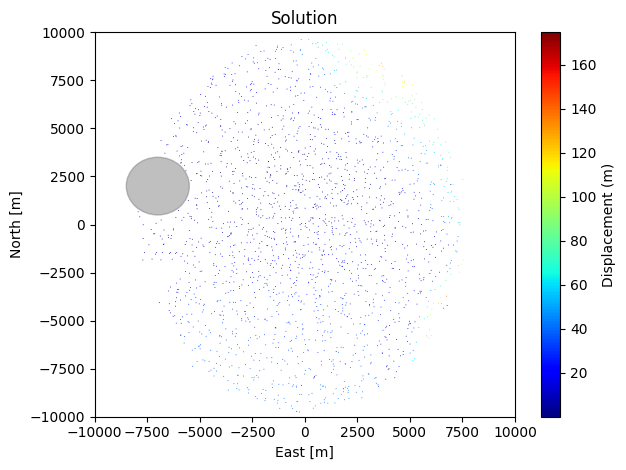

In [48]:
# Plot x0 and gradient from from x0 to x
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# plt.scatter(x0[:, 0], x0[:, 1], s=1, c=sigma, cmap='jet')
arrow_length = jnp.linalg.norm(x - x0, axis=-1)
ar = plt.quiver(x0[:, 0], x0[:, 1], x[:, 0] - x0[:, 0], x[:, 1] - x0[:, 1], arrow_length, scale=1, scale_units='xy',
                cmap='jet')
# color bar
plt.colorbar(ar, label='Displacement (m)')
# grey circle
circle = plt.Circle(exclusion_center, exclusion_radius, color='grey', fill=True, alpha=0.5)
plt.gca().add_artist(circle)
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.xlim(-10e3, 10e3)
plt.ylim(-10e3, 10e3)
plt.title('Solution')
plt.tight_layout()
plt.savefig('array_solution.png')
plt.show()

In [97]:
problem = OptimisationProblem(num_radial_bins=100, num_theta_bins=10, fwhm=3.3 * au.arcsec, lmin=3.3 * au.arcsec,
                              lmax=1 * au.arcmin)

antennas0, antenna1, antenna2, lm, freq = problem.create_data(
    antennas=antennas, obstime=obstime, array_location=array_location
)

ref_psf = jax.jit(problem.compute_psf)(antennas0, antenna1, antenna2, lm, freq)  # [Nr, Nt]
psf0 = jax.jit(problem.compute_psf)(x0, antenna1, antenna2, lm, freq)  # [Nr, Nt]
psf = jax.jit(problem.compute_psf)(x, antenna1, antenna2, lm, freq)  # [Nr, Nt]

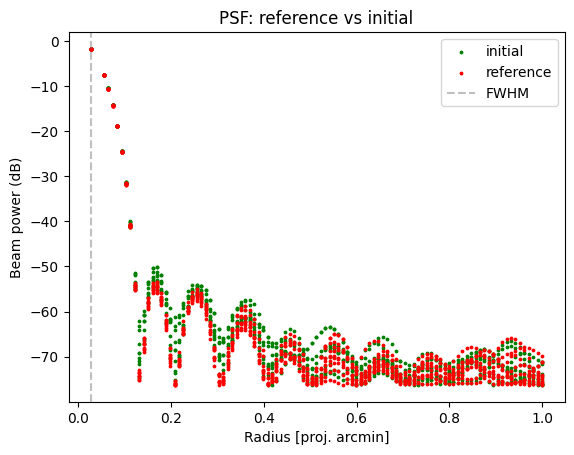

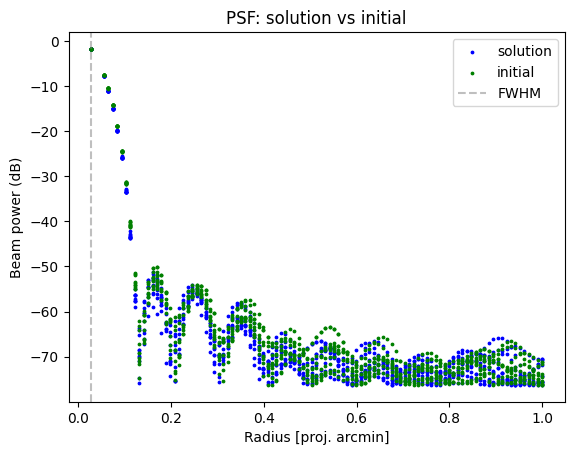

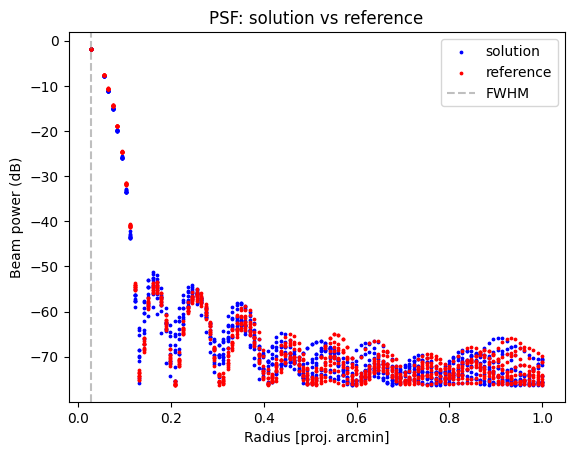

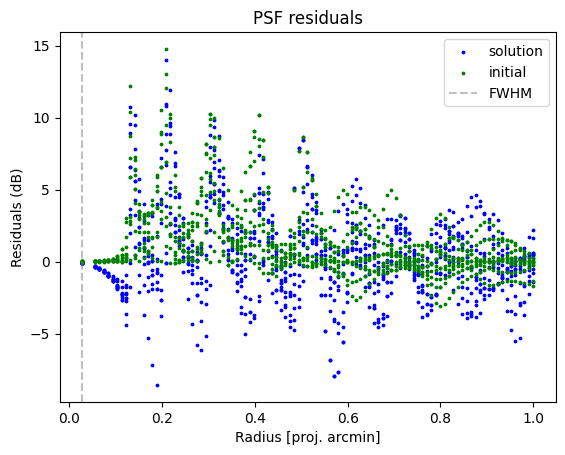

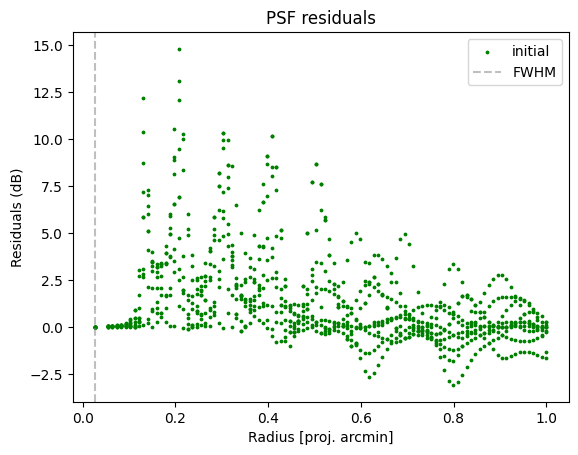

In [107]:
for _psf, name, c in (
        # [psf, 'solution', 'blue'],
        [psf0, 'initial', 'green'],
        [ref_psf, 'reference', 'red'],

):
    radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
    log_psf_radii = np.log(_psf).flatten() * 10. * jnp.log(jnp.e)
    plt.scatter(radii, log_psf_radii, c=c, s=3, label=name)

plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Beam power (dB)')
plt.title('PSF: reference vs initial')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_reference_vs_initial_inner.png')
plt.show()

for _psf, name, c in (
        [psf, 'solution', 'blue'],
        # [ref_psf, 'reference', 'red'],
        [psf0, 'initial', 'green'],
):
    radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
    log_psf_radii = np.log(_psf).flatten() * 10. * jnp.log(jnp.e)
    plt.scatter(radii, log_psf_radii, c=c, s=3, label=name)

plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Beam power (dB)')
plt.title('PSF: solution vs initial')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_solution_vs_initial_inner.png')
plt.show()

for _psf, name, c in (
        [psf, 'solution', 'blue'],
        [ref_psf, 'reference', 'red'],
        # [psf0, 'initial', 'green'],
):
    radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
    log_psf_radii = np.log(_psf).flatten() * 10. * jnp.log(jnp.e)
    plt.scatter(radii, log_psf_radii, c=c, s=3, label=name)
plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Beam power (dB)')
plt.title('PSF: solution vs reference')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_solution_vs_ref_inner.png')
plt.show()

residuals = (np.log(psf.flatten()) - np.log(ref_psf.flatten())) * 10. * jnp.log(jnp.e)
residuals0 = (np.log(psf0.flatten()) - np.log(ref_psf.flatten())) * 10. * jnp.log(jnp.e)
radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
plt.scatter(radii, residuals, s=3, c='blue', label='solution')
plt.scatter(radii, residuals0, s=3, c='green', label='initial')
plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Residuals (dB)')
plt.title('PSF residuals')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_residuals_soluion_vs_ref_inner.png')
plt.show()

residuals0 = (np.log(psf0.flatten()) - np.log(ref_psf.flatten())) * 10. * jnp.log(jnp.e)
radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
plt.scatter(radii, residuals0, s=3, c='green', label='initial')
plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Residuals (dB)')
plt.title('PSF residuals')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_residuals_initial_vs_ref_inner.png')
plt.show()



In [95]:
problem = OptimisationProblem(num_radial_bins=300, num_theta_bins=10, fwhm=3.3 * au.arcsec, lmin=3.3 * au.arcsec,
                              lmax=1 * au.deg)

antennas0, antenna1, antenna2, lm, freq = problem.create_data(
    antennas=antennas, obstime=obstime, array_location=array_location
)

ref_psf = jax.jit(problem.compute_psf)(antennas0, antenna1, antenna2, lm, freq)  # [Nr, Nt]
psf0 = jax.jit(problem.compute_psf)(x0, antenna1, antenna2, lm, freq)  # [Nr, Nt]
psf = jax.jit(problem.compute_psf)(x, antenna1, antenna2, lm, freq)  # [Nr, Nt]

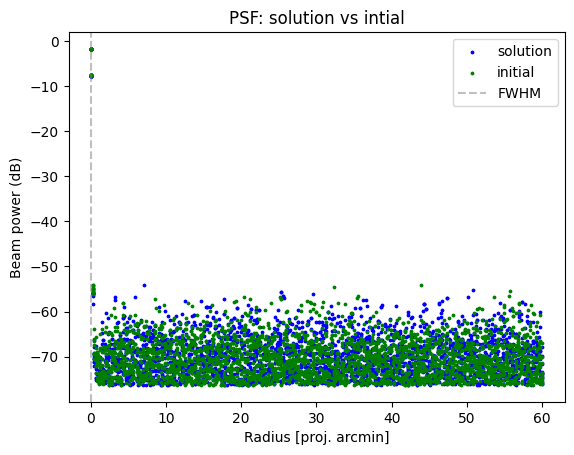

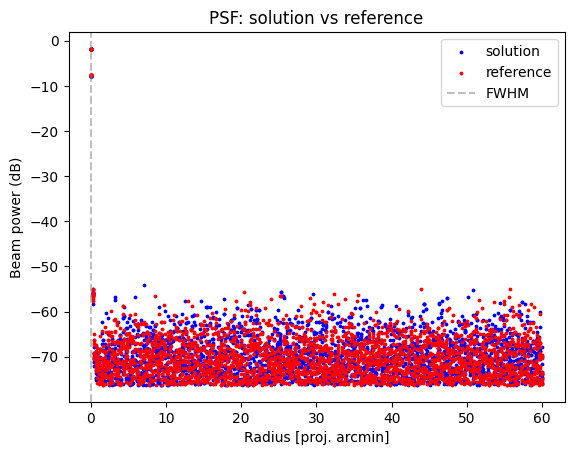

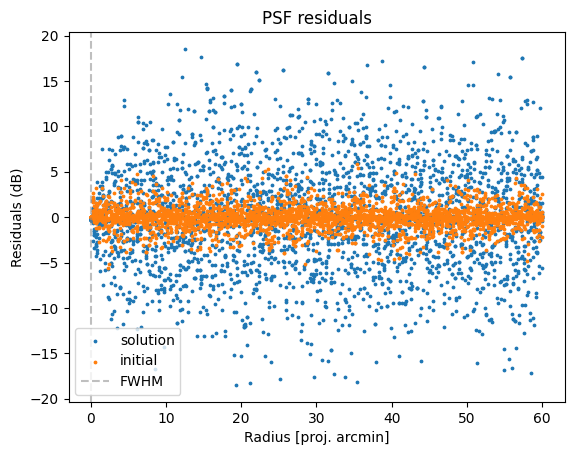

In [96]:
for _psf, name, c in (
        [psf, 'solution', 'blue'],
        # [ref_psf, 'reference', 'red'],
        [psf0, 'initial', 'green'],
):
    radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
    log_psf_radii = np.log(_psf).flatten() * 10. * jnp.log(jnp.e)
    plt.scatter(radii, log_psf_radii, c=c, s=3, label=name)
plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Beam power (dB)')
plt.title('PSF: solution vs intial')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_solution_vs_initial_full.png')
plt.show()

for _psf, name, c in (
        [psf, 'solution', 'blue'],
        [ref_psf, 'reference', 'red'],
        # [psf0, 'initial', 'green'],
):
    radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
    log_psf_radii = np.log(_psf).flatten() * 10. * jnp.log(jnp.e)
    plt.scatter(radii, log_psf_radii, c=c, s=3, label=name)
plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Beam power (dB)')
plt.title('PSF: solution vs reference')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_solution_vs_ref_full.png')
plt.show()

residuals = (np.log(psf.flatten()) - np.log(ref_psf.flatten())) * 10. * jnp.log(jnp.e)
residuals0 = (np.log(psf0.flatten()) - np.log(ref_psf.flatten())) * 10. * jnp.log(jnp.e)
radii = np.linalg.norm(lm, axis=-1).flatten() * 180 / np.pi * 60
plt.scatter(radii, residuals, s=3, label='solution')
plt.scatter(radii, residuals0, s=3, label='initial')
plt.xlabel('Radius [proj. arcmin]')
plt.ylabel('Residuals (dB)')
plt.title('PSF residuals')
plt.axvline(3.3 / 2 / 60, color='grey', linestyle='--', label='FWHM', alpha=0.5)
plt.legend()
plt.savefig('psf_residuals_soluion_vs_ref_full.png')
plt.show()



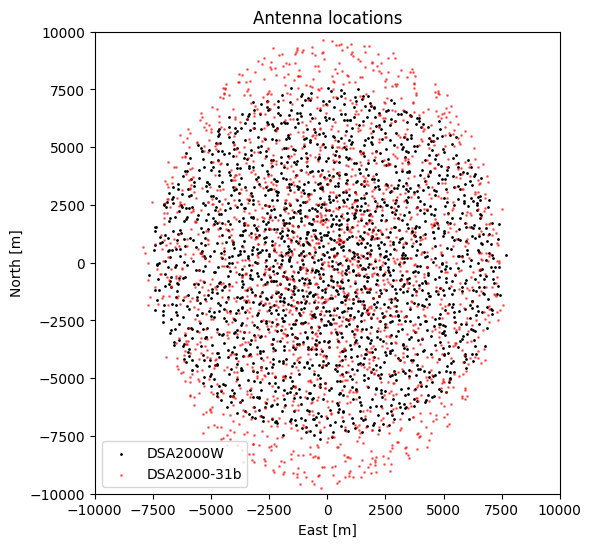

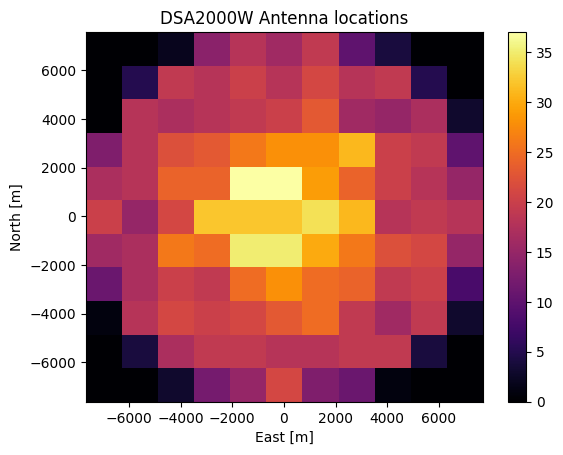

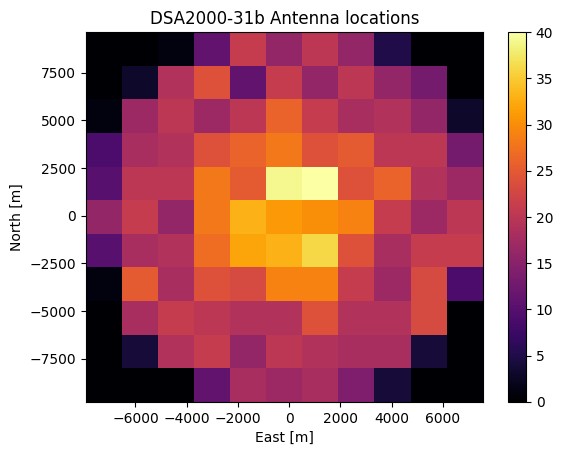

In [25]:
freq = 700 * au.MHz
fill_registries()

array0 = array_registry.get_instance(array_registry.get_match('dsa2000W'))
antennas0 = array0.get_antennas()
location = array0.get_array_location()
obstime = at.Time('2021-01-01T00:00:00', format='isot', scale='utc')

antennas0_enu_xyz = antennas0.get_itrs(
    obstime=obstime, location=location).transform_to(
    ENU(obstime=obstime, location=location)).cartesian.xyz.to('m').T.value

array = array_registry.get_instance(array_registry.get_match('dsa2000_31b'))
# array = DSA200031b()
antennas = array.get_antennas()
location = array.get_array_location()
obstime = at.Time('2021-01-01T00:00:00', format='isot', scale='utc')

antennas_enu_xyz = antennas.get_itrs(
    obstime=obstime, location=location).transform_to(
    ENU(obstime=obstime, location=location)).cartesian.xyz.to('m').T.value

# antennas_enu_xyz = rotate_coords_to_dec0(antennas_enu_xyz, latitude)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(antennas0_enu_xyz[:, 0], antennas0_enu_xyz[:, 1],
           c='black', s=1, label='DSA2000W')
ax.scatter(antennas_enu_xyz[:, 0], antennas_enu_xyz[:, 1],
           c='red', s=1, label='DSA2000-31b', alpha=0.5)
ax.set_xlabel('East [m]')
ax.set_ylabel('North [m]')
ax.set_title('Antenna locations')
ax.set_xlim(-10e3, 10e3)
ax.set_ylim(-10e3, 10e3)
ax.legend()
fig.savefig('antennas_W_vs_31b.png')
plt.show()

# Create 2d hist
plt.hist2d(antennas0_enu_xyz[:, 0], antennas0_enu_xyz[:, 1], bins=11, cmap='inferno')
plt.colorbar()
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.title('DSA2000W Antenna locations')
plt.savefig('antennas_W_hist.png')
plt.show()

plt.hist2d(antennas_enu_xyz[:, 0], antennas_enu_xyz[:, 1], bins=11, cmap='inferno')
plt.colorbar()
plt.xlabel('East [m]')
plt.ylabel('North [m]')
plt.title('DSA2000-31b Antenna locations')
plt.savefig('antennas_31b_hist.png')
plt.show()